In [ ]:
!pip install shimmy
!pip install stable_baselines3
!pip install gymnasium.wrappers.monitoring
!pip install stable_baselines3 gymnasium
!pip install ppo

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 954.3/954.3 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.3/182.3 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 9.8 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-man

In [65]:
import gym
from gym import spaces
import numpy as np
import matplotlib.pyplot as plt
from stable_baselines3 import PPO
from stable_baselines3.common.evaluation import evaluate_policy

class ThreeDOFRobotEnv(gym.Env):
    def __init__(self):
        super(ThreeDOFRobotEnv, self).__init__()
        self.max_torque = 1.0
        self.max_speed = np.pi
        self.dt = 0.05
        self.goal = np.array([1.5, 1.5])
        self.max_distance = 3.0  # Maximum allowable distance from the goal
        self.barrier = np.array([0.75, 0.75])
        self.barrier_radius = 0.1  # Radius of the barrier

        self.action_space = spaces.Box(low=-self.max_torque, high=self.max_torque, shape=(3,), dtype=np.float32)
        self.observation_space = spaces.Box(low=-self.max_speed, high=self.max_speed, shape=(6,), dtype=np.float32)

        self.reset()

    def reset(self):
        self.state = np.zeros(6)
        self.prev_distance = self._get_distance_to_goal()
        self.elapsed_time = 0  # Reset the elapsed time
        return self.state

    def step(self, action):
        th1, th2, th3, dth1, dth2, dth3 = self.state
        u1, u2, u3 = action

        dth1 = np.clip(dth1 + self.dt * u1, -self.max_speed, self.max_speed)
        dth2 = np.clip(dth2 + self.dt * u2, -self.max_speed, self.max_speed)
        dth3 = np.clip(dth3 + self.dt * u3, -self.max_speed, self.max_speed)

        th1 += self.dt * dth1
        th2 += self.dt * dth2
        th3 += self.dt * dth3

        self.state = np.array([th1, th2, th3, dth1, dth2, dth3])
        self.elapsed_time += self.dt  # Increment the elapsed time

        reward, done = self._compute_reward()
        return self.state, reward, done, {}

    def _get_distance_to_goal(self):
        x = np.cos(self.state[0]) + np.cos(self.state[0] + self.state[1]) + np.cos(self.state[0] + self.state[1] + self.state[2])
        y = np.sin(self.state[0]) + np.sin(self.state[0] + self.state[1]) + np.sin(self.state[0] + self.state[1] + self.state[2])
        distance = np.linalg.norm(self.goal - np.array([x, y]))
        return distance

    def _get_end_effector_position(self):
        th1, th2, th3, _, _, _ = self.state
        x = np.cos(th1) + np.cos(th1 + th2) + np.cos(th1 + th2 + th3)
        y = np.sin(th1) + np.sin(th1 + th2) + np.sin(th1 + th2 + th3)
        return np.array([x, y])

    def _check_collision_with_barrier(self):
        end_effector_pos = self._get_end_effector_position()
        return np.linalg.norm(end_effector_pos - self.barrier) <= self.barrier_radius

    def _compute_reward(self):
        current_distance = self._get_distance_to_goal()
        reward = 0
        done = False

        if self._check_collision_with_barrier():
            reward -= 5.0  # Heavy penalty for collision with barrier
            done = True
        elif current_distance > self.max_distance:
            reward -= 1.0  # Penalty for being too far from the goal
            done = True
        elif current_distance < 0.2:
            reward += 1.0  # Reward for reaching the goal
            done = True
        else:
            reward += (self.prev_distance - current_distance) * 15  # Reward for getting closer to the goal
            reward -= 0.01 * self.elapsed_time  # Small penalty for time taken

        self.prev_distance = current_distance

        reward -= 0.06 * (abs(action[0]) + abs(action[1]) + abs(action[2]))
        # Encourage smoother movements by penalizing large velocities
        reward -= 0.06 * (abs(self.state[3]) + abs(self.state[4]) + abs(self.state[5]))

        return reward, done

    def render(self, mode='human'):
        th1, th2, th3, _, _, _ = self.state
        x1 = np.cos(th1)
        y1 = np.sin(th1)
        x2 = x1 + np.cos(th1 + th2)
        y2 = y1 + np.sin(th1 + th2)
        x3 = x2 + np.cos(th1 + th2 + th3)
        y3 = y2 + np.sin(th1 + th2 + th3)

        plt.figure()
        plt.plot([0, x1], [0, y1], 'ro-')
        plt.plot([x1, x2], [y1, y2], 'ro-')
        plt.plot([x2, x3], [y2, y3], 'ro-')
        plt.plot(self.goal[0], self.goal[1], 'go')
        plt.plot(self.barrier[0], self.barrier[1], 'ko')
        circle = plt.Circle(self.barrier, self.barrier_radius, color='k', fill=True)
        plt.gca().add_patch(circle)
        plt.xlim(-3, 3)
        plt.ylim(-3, 3)
        plt.xlabel("X")
        plt.ylabel("Y")
        plt.title("3-DOF Planar Robot")
        plt.legend(["Link 1", "Link 2", "Link 3", "Goal", "Barrier"])
        plt.grid()
        plt.show()
# Callback to store rewards during training
class RewardCallback(BaseCallback):
    def __init__(self, verbose=0):
        super(RewardCallback, self).__init__(verbose)
        self.rewards = []

    def _on_step(self) -> bool:
        self.rewards.append(self.locals['rewards'])
        return True

    def _on_training_end(self) -> None:
        plt.plot(self.rewards)
        plt.xlabel('Steps')
        plt.ylabel('Rewards')
        plt.title('Training Rewards')
        plt.show()



Output()

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 140      |
|    ep_rew_mean     | -44.9    |
| time/              |          |
|    fps             | 584      |
|    iterations      | 1        |
|    time_elapsed    | 3        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 164         |
|    ep_rew_mean          | -49.8       |
| time/                   |             |
|    fps                  | 499         |
|    iterations           | 2           |
|    time_elapsed         | 8           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.008357828 |
|    clip_fraction        | 0.0355      |
|    clip_range           | 0.2         |
|    entropy_loss  

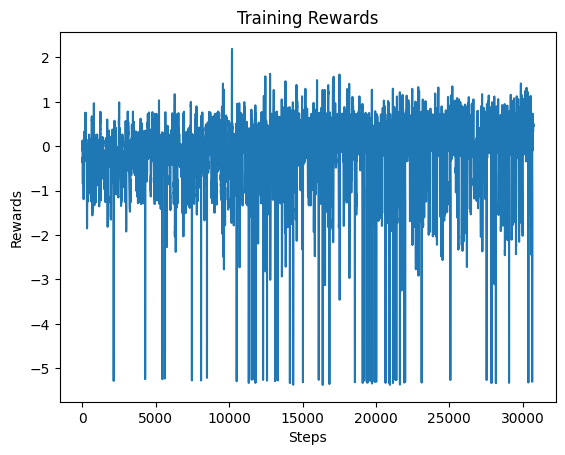

Mean reward: 20.430294915568084 +/- 0.0


In [66]:
# Create the environment
env = ThreeDOFRobotEnv()

# # Create and train the model
# model = PPO('MlpPolicy', env, verbose=1)
# model.learn(total_timesteps=50000)
# Create and train the model with callback
callback = RewardCallback()
model = PPO('MlpPolicy', env, verbose=1)
model.learn(total_timesteps=30000, callback=callback,progress_bar = True)

# Evaluate the model
mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=10)
print(f"Mean reward: {mean_reward} +/- {std_reward}")



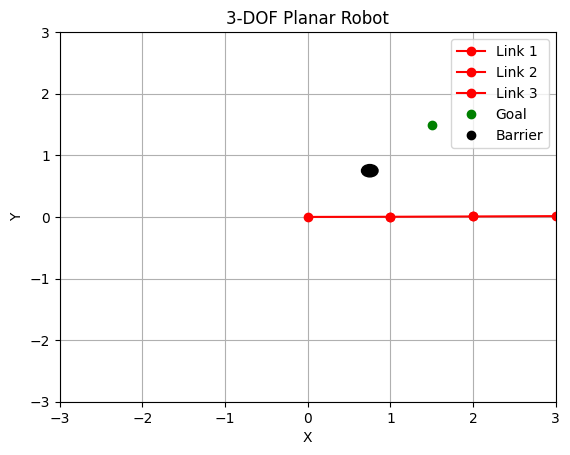

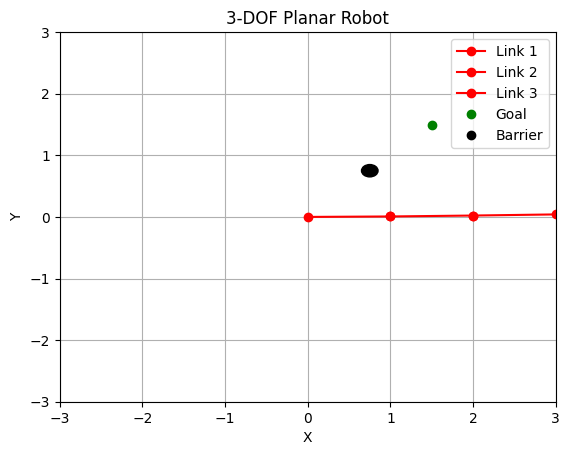

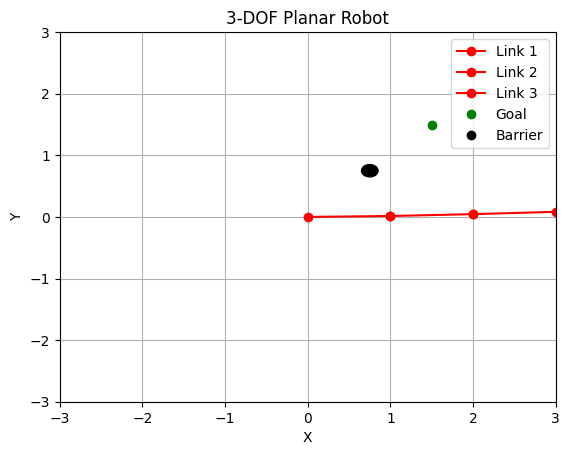

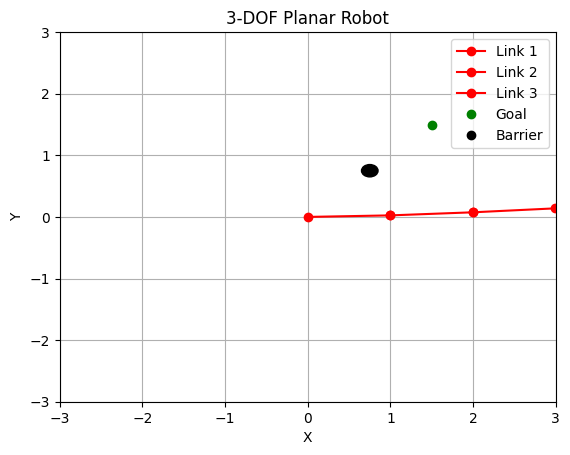

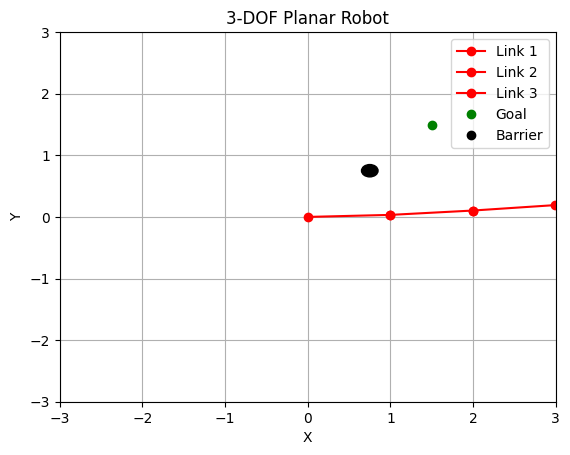

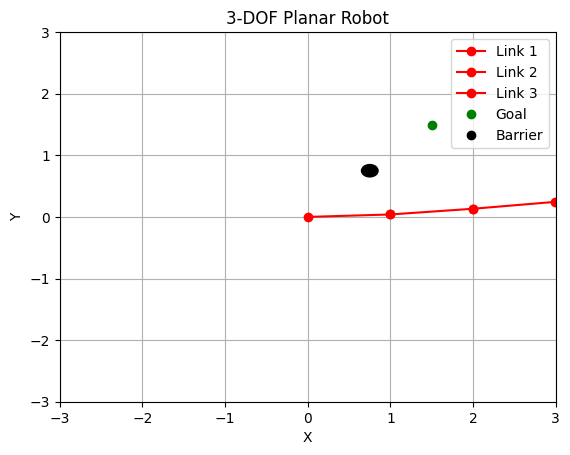

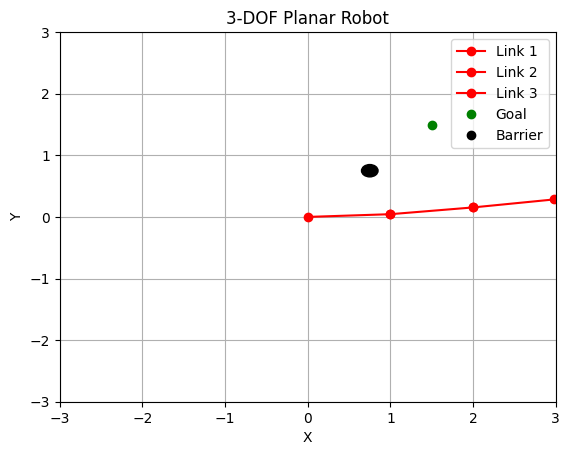

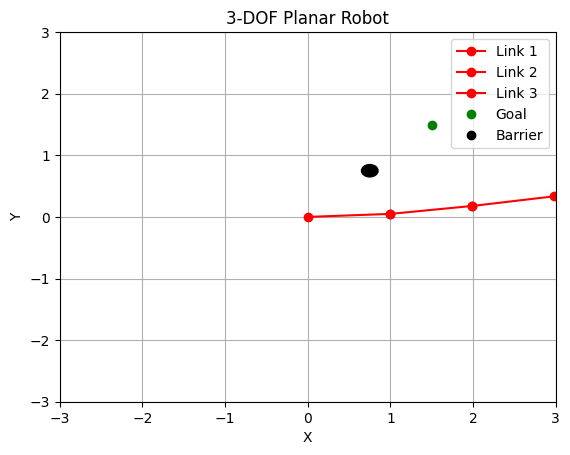

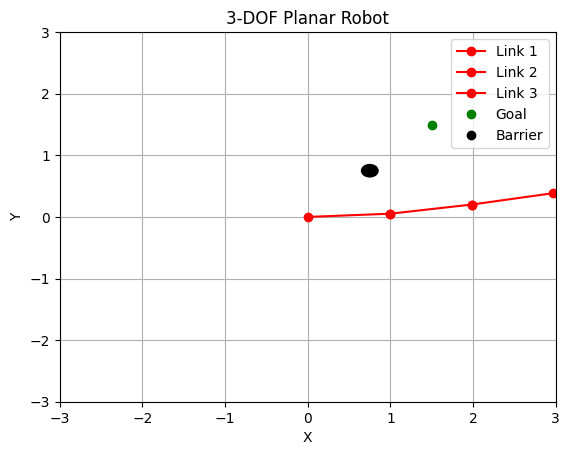

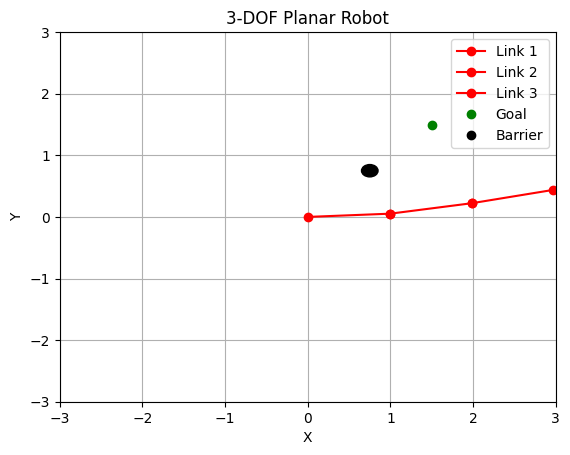

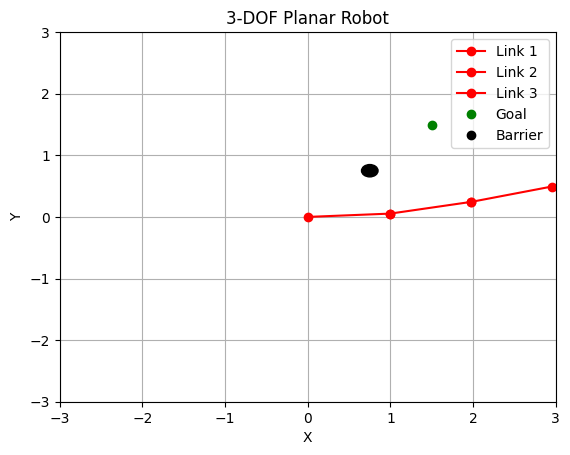

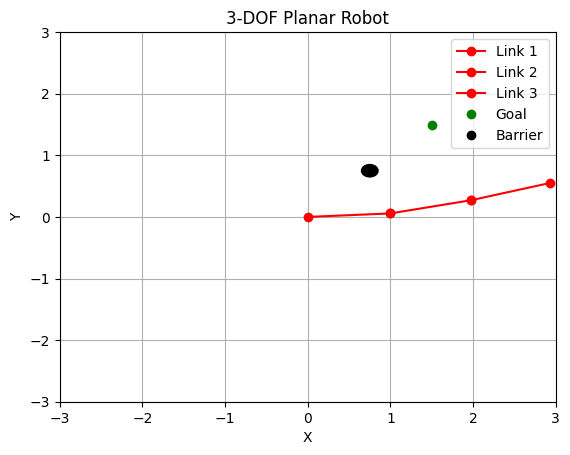

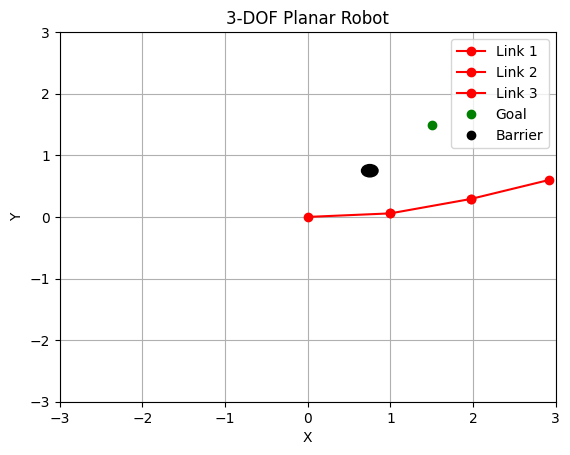

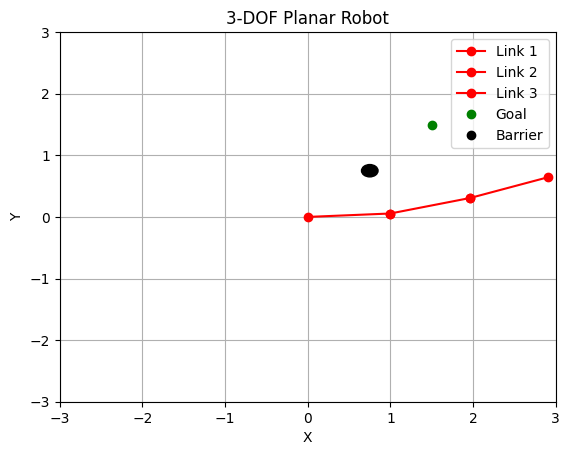

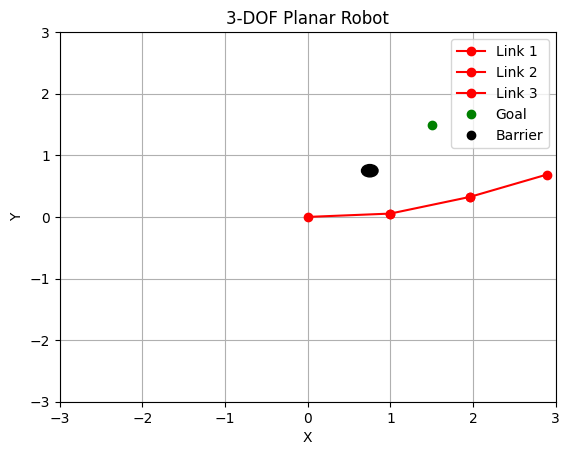

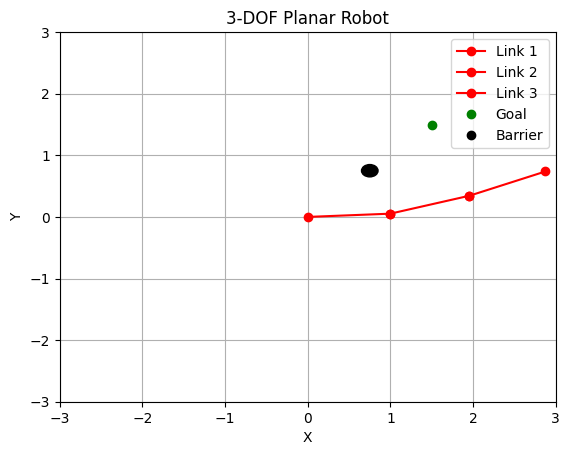

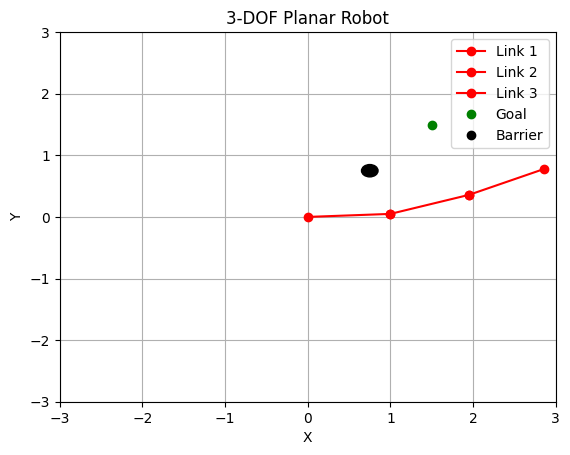

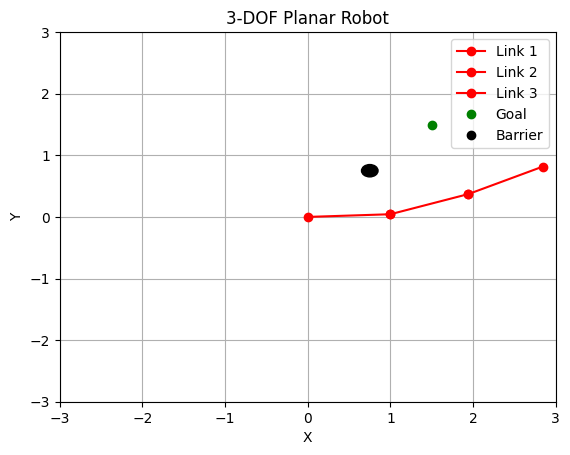

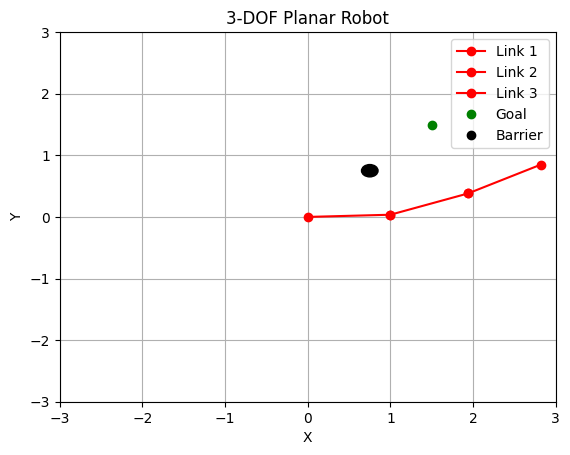

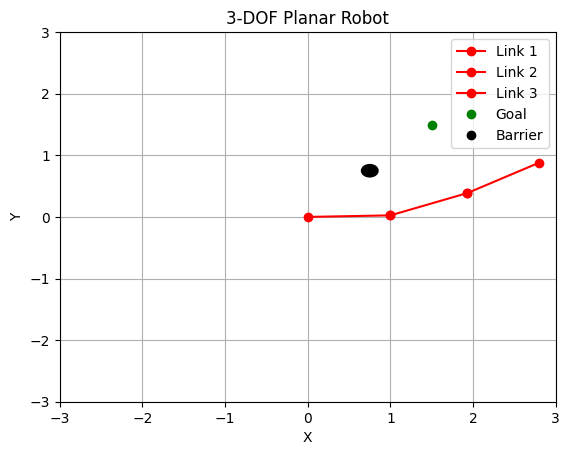

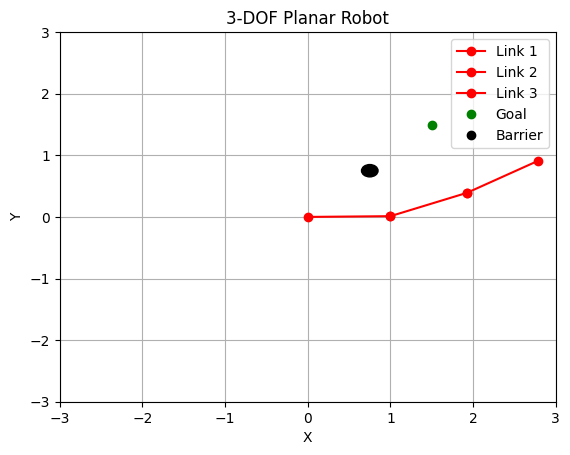

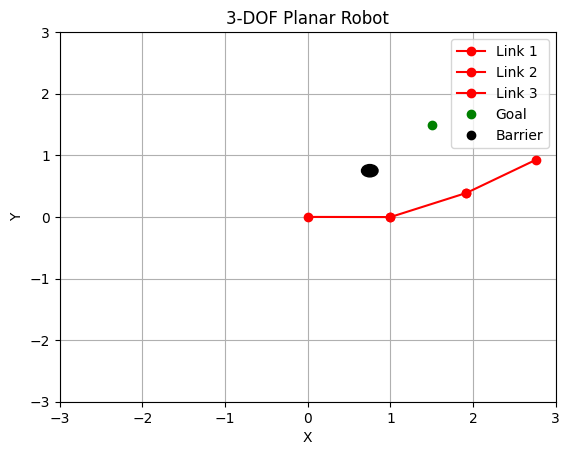

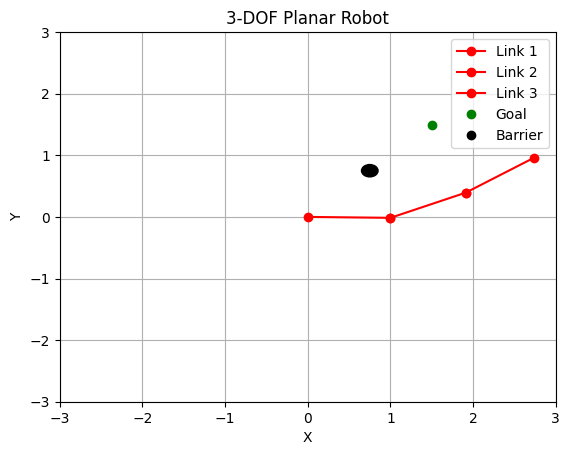

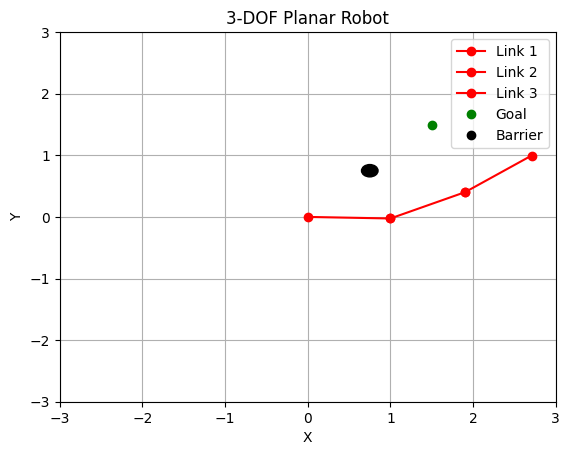

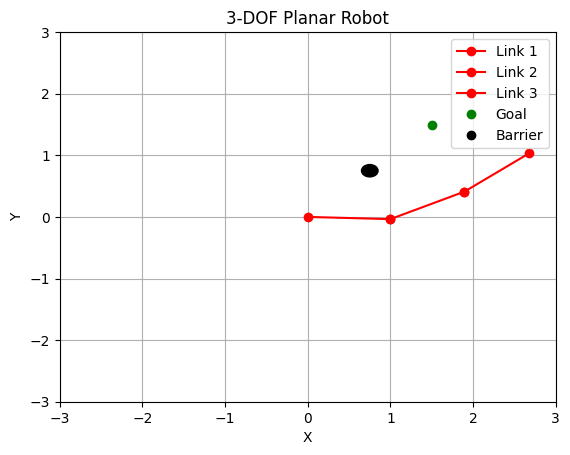

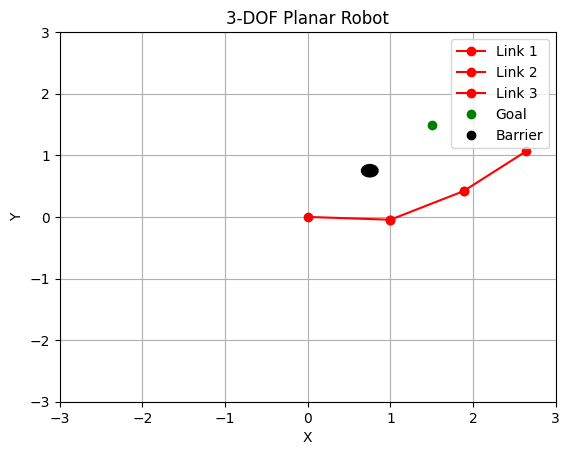

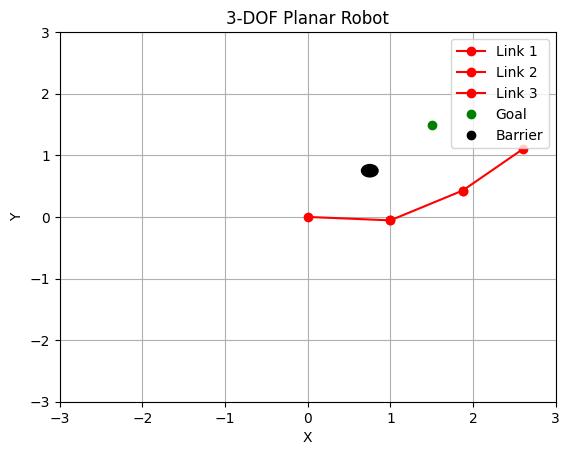

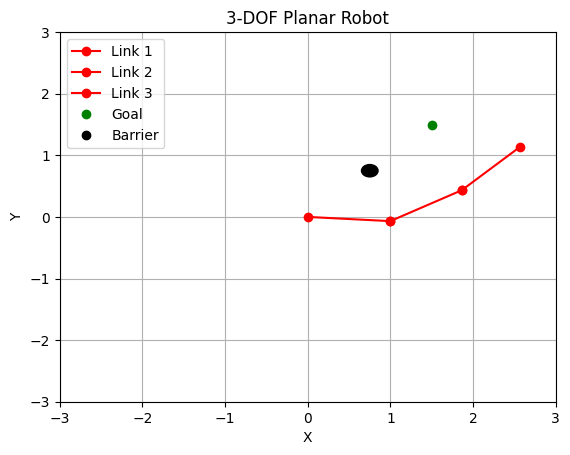

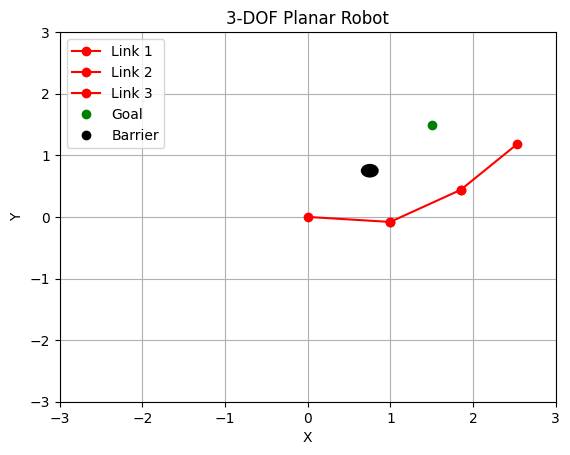

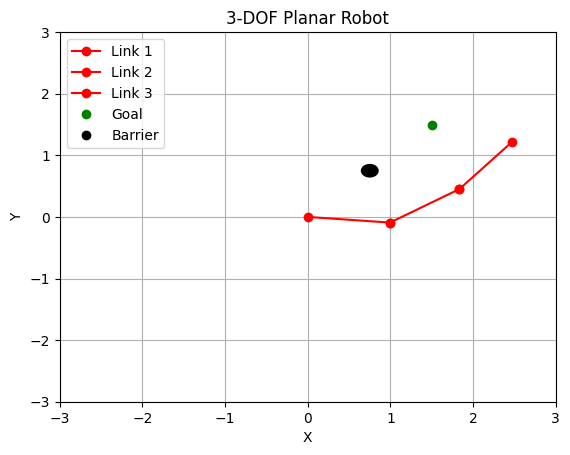

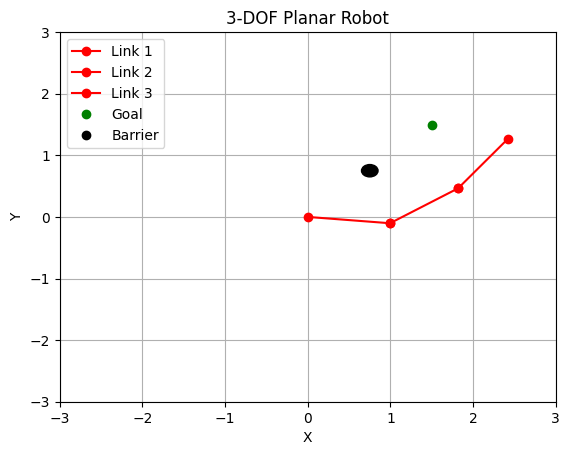

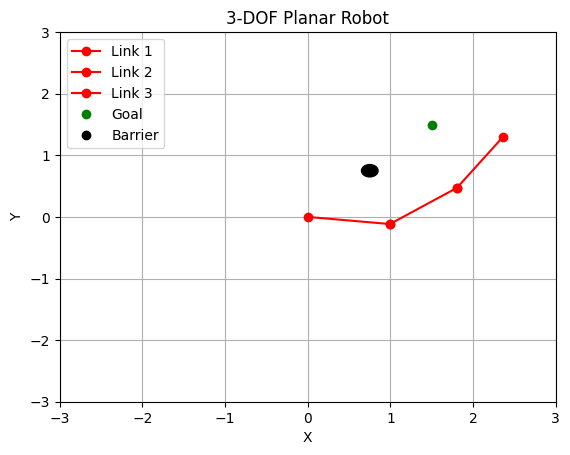

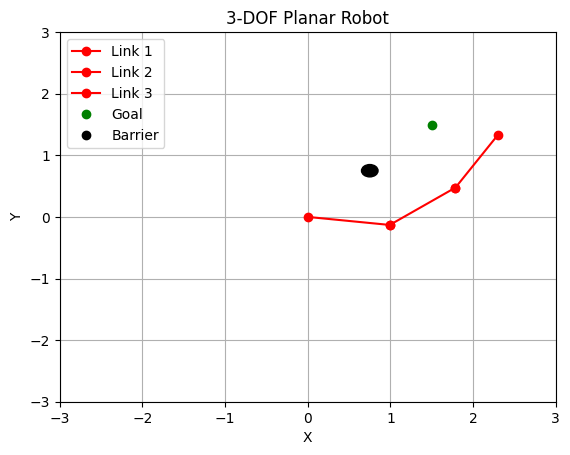

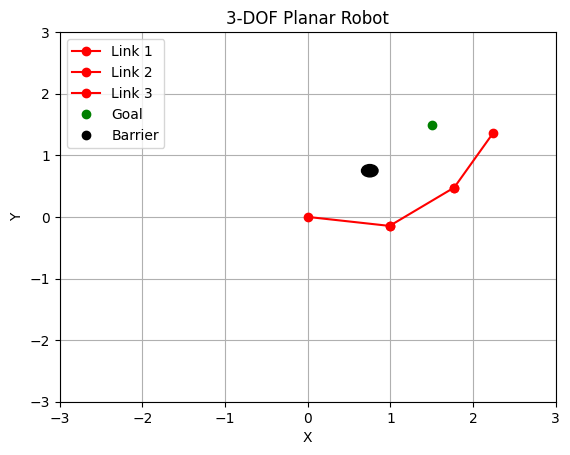

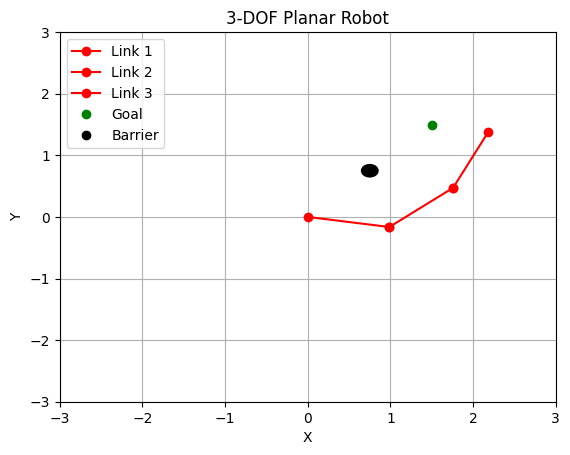

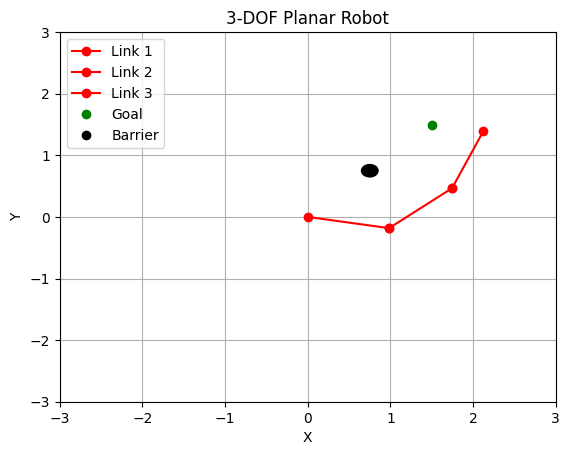

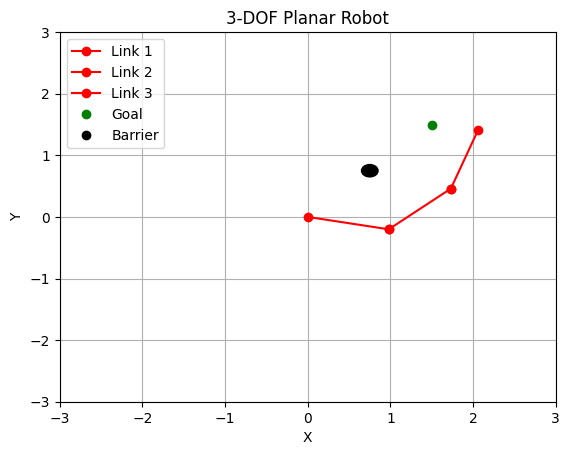

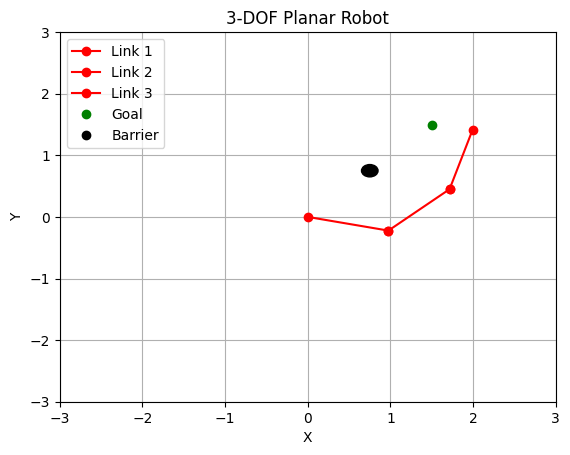

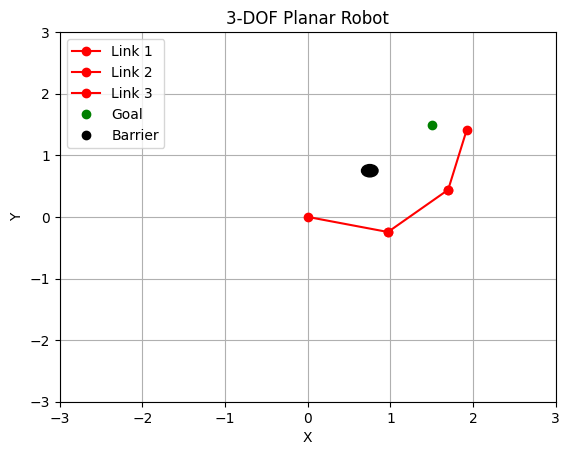

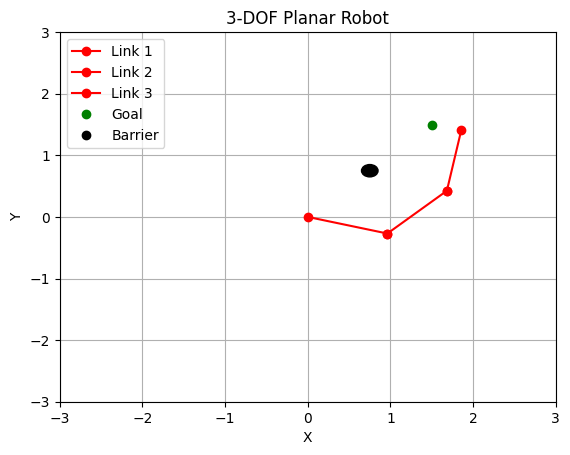

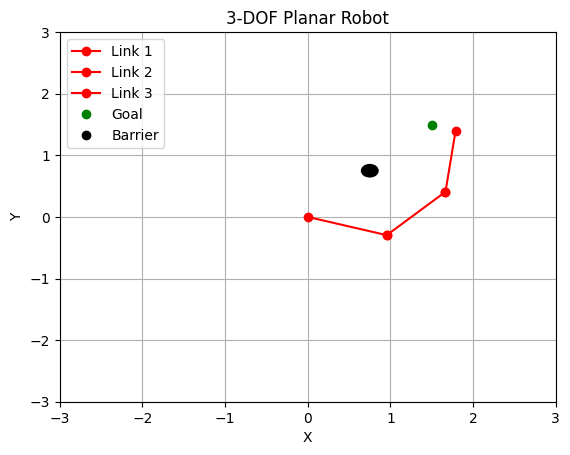

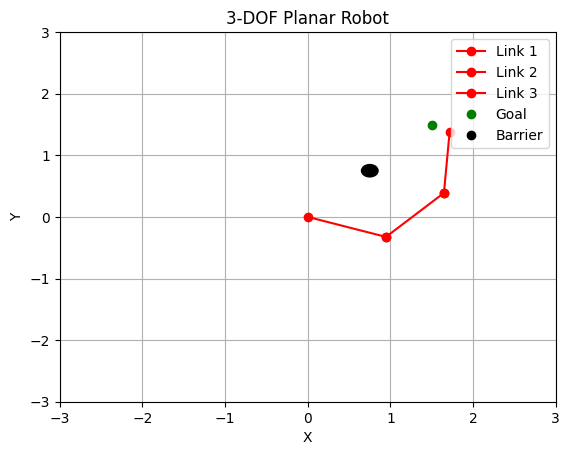

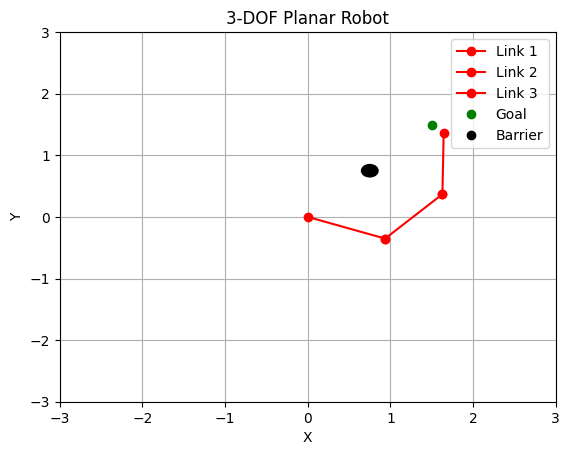

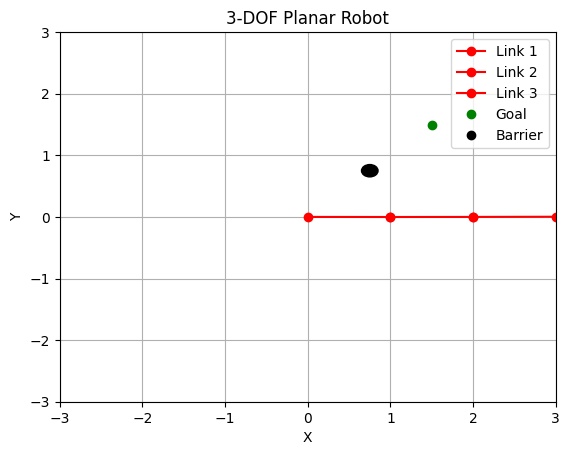

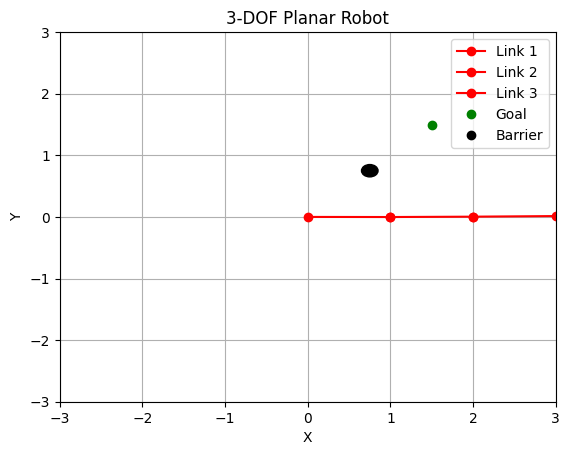

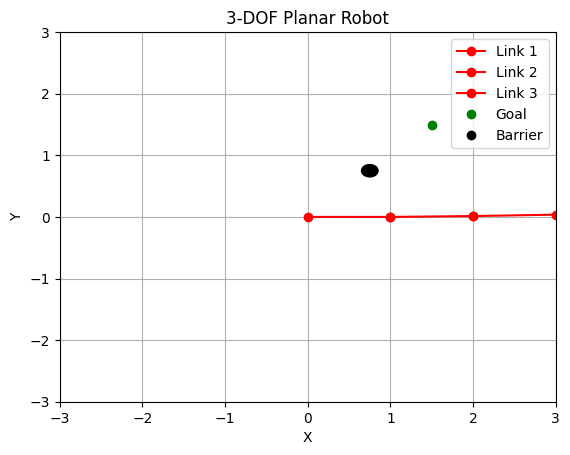

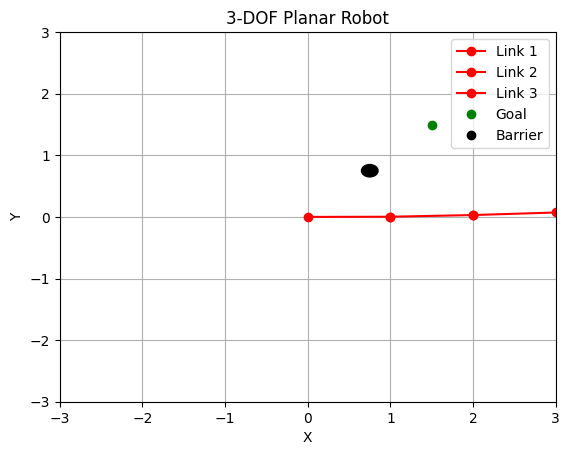

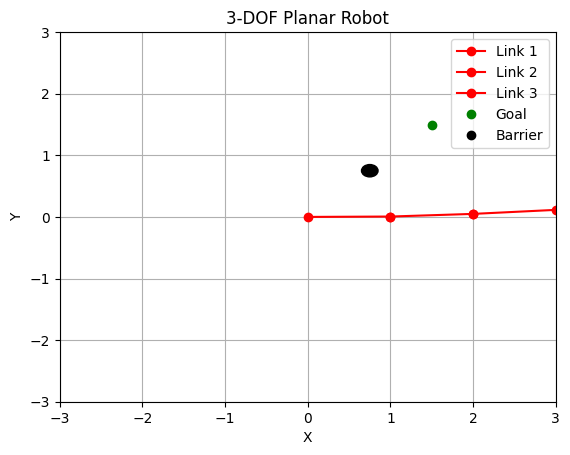

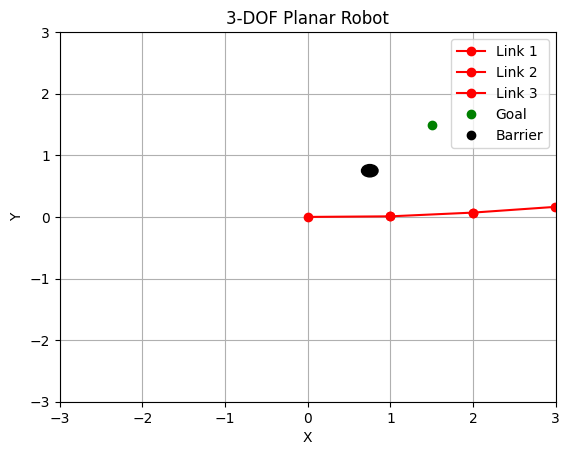

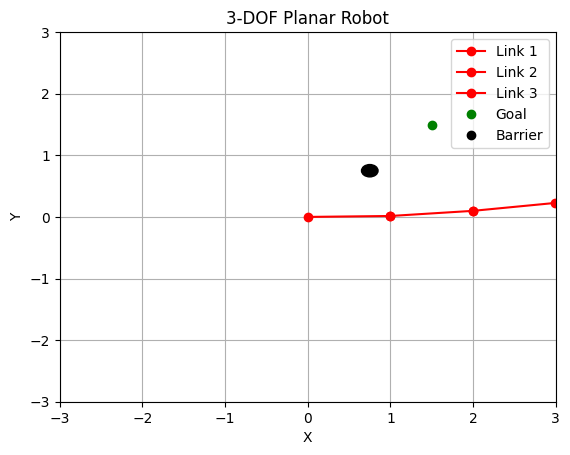

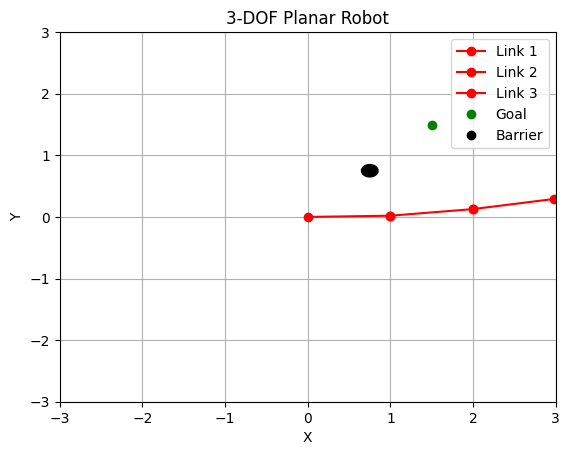

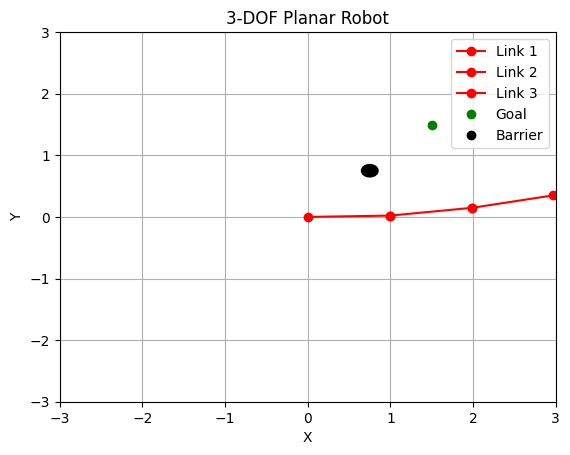

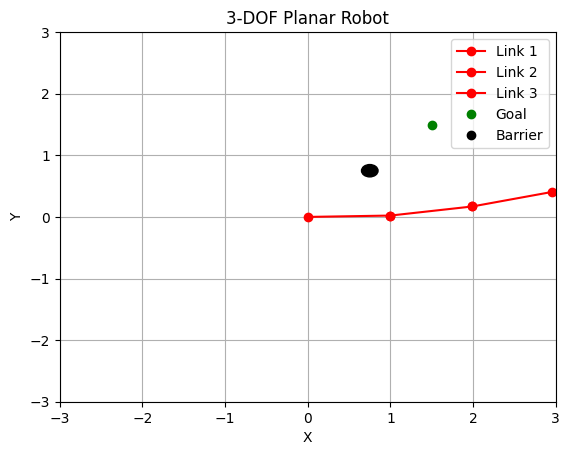

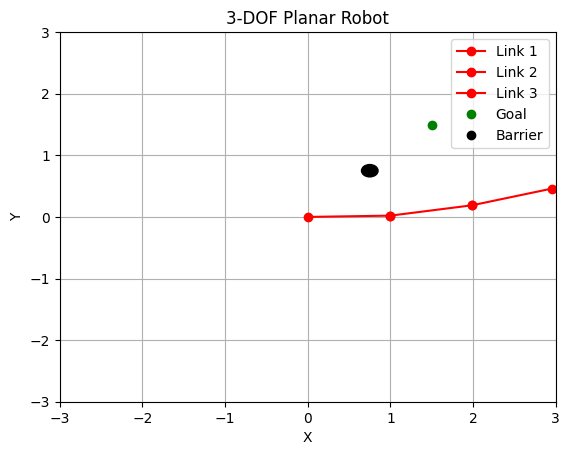

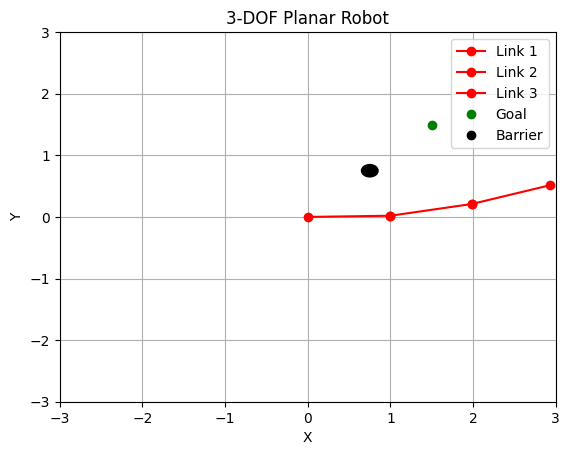

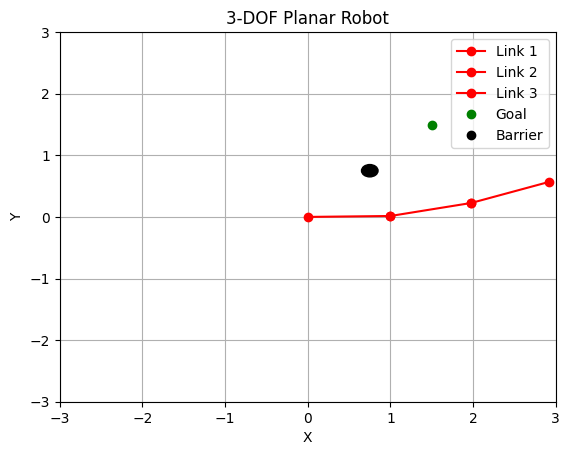

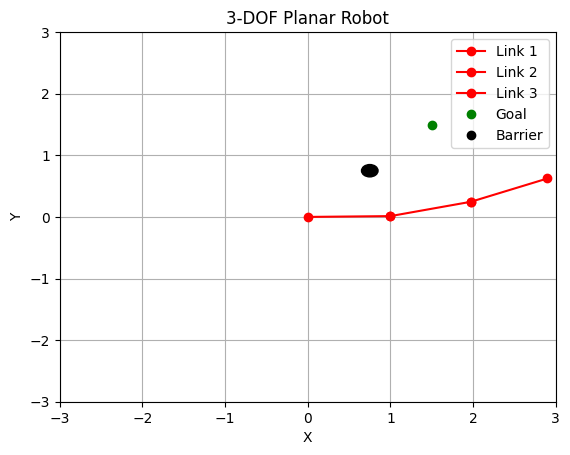

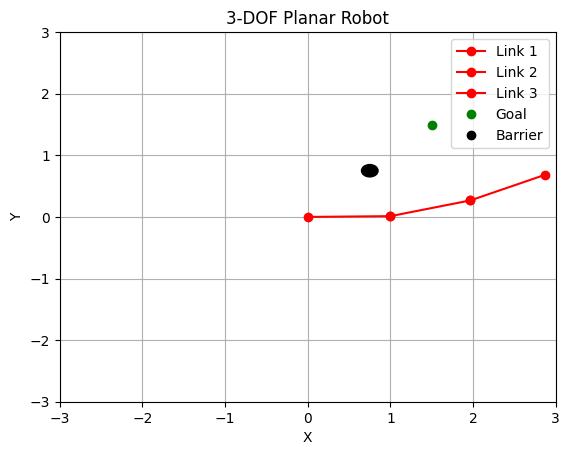

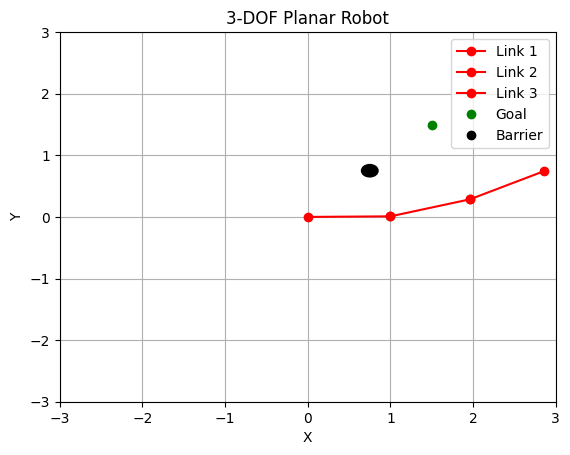

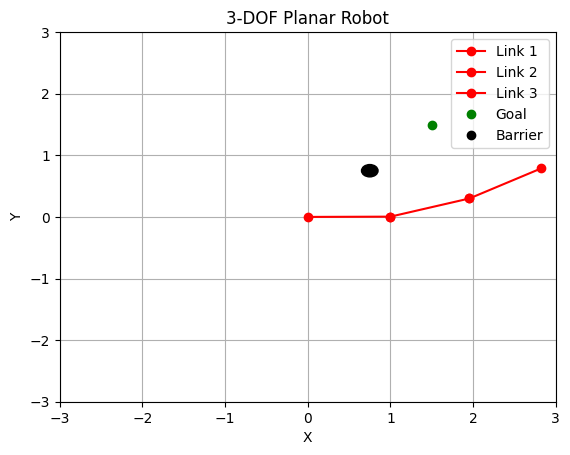

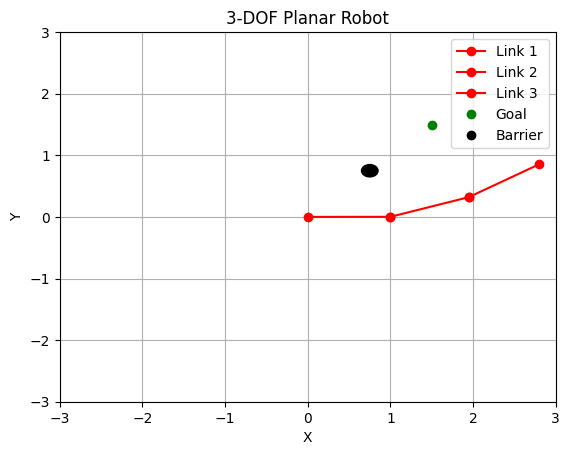

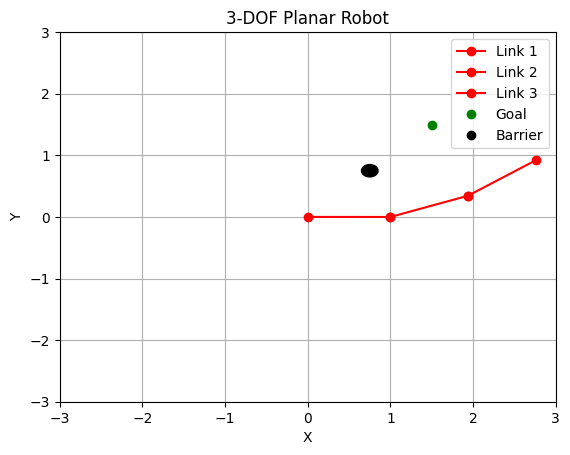

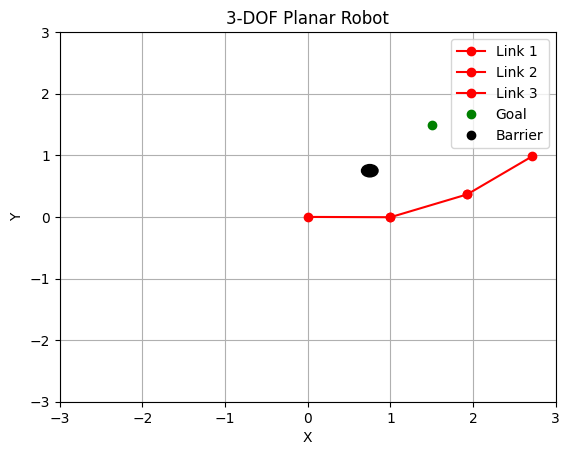

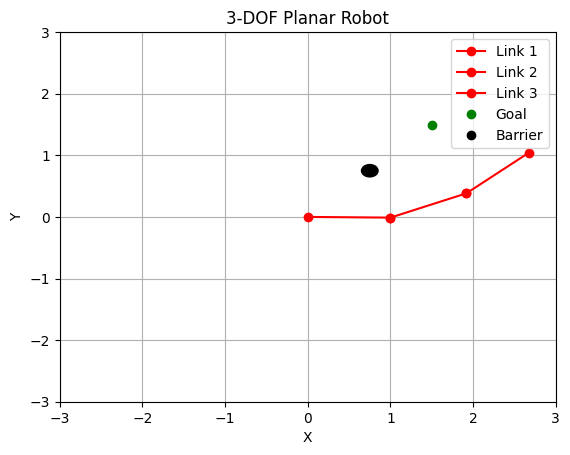

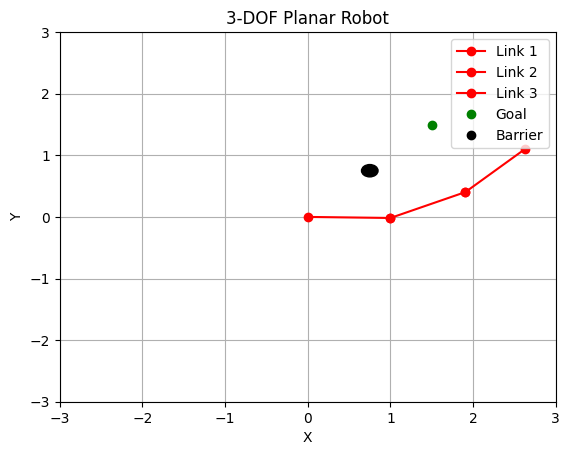

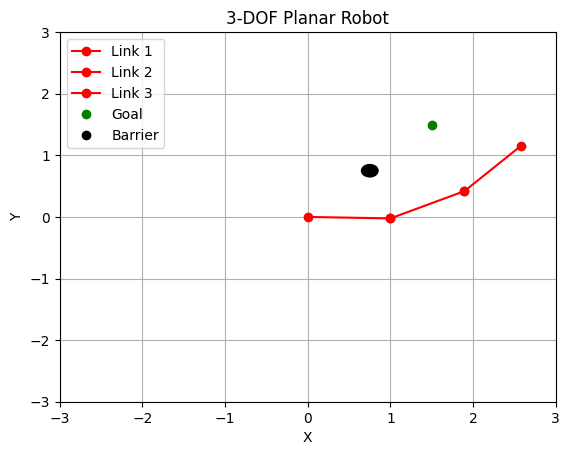

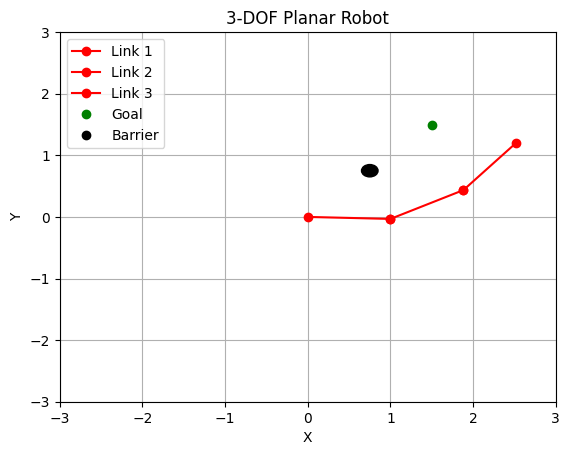

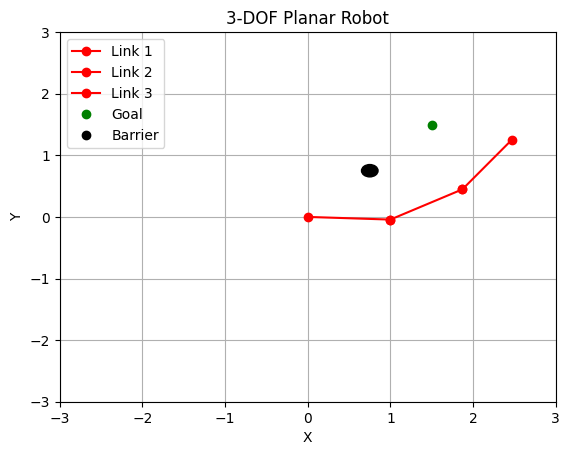

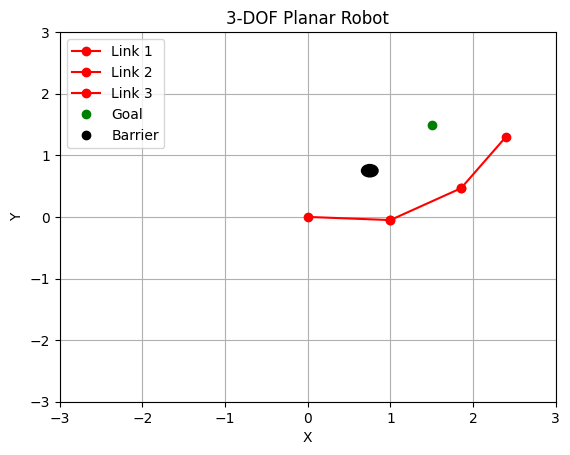

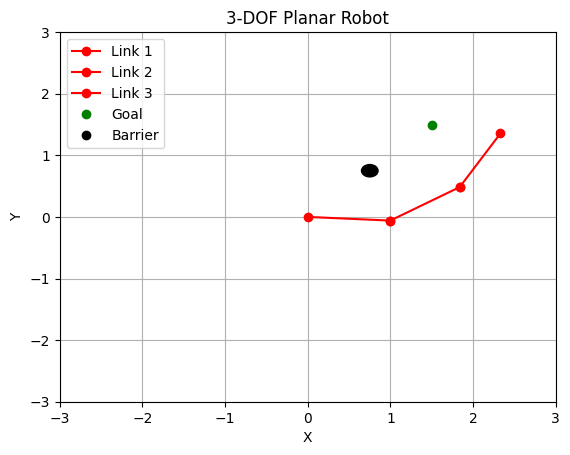

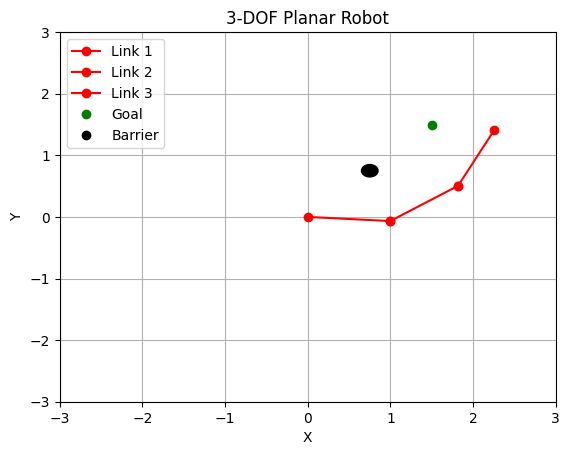

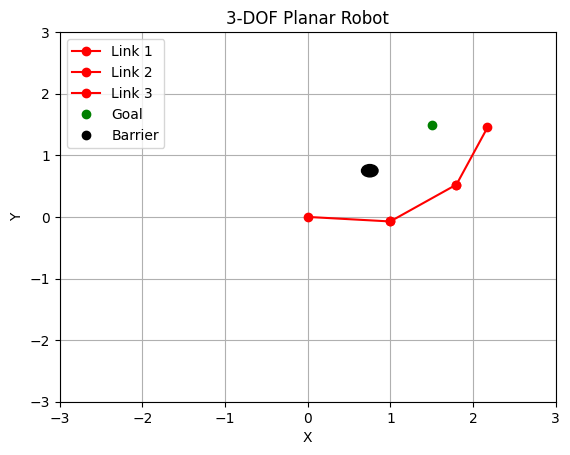

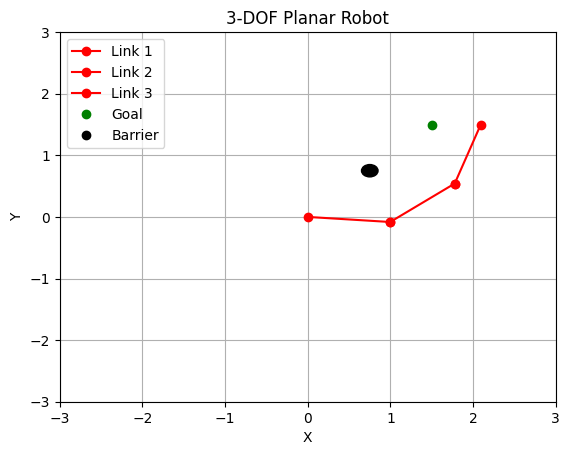

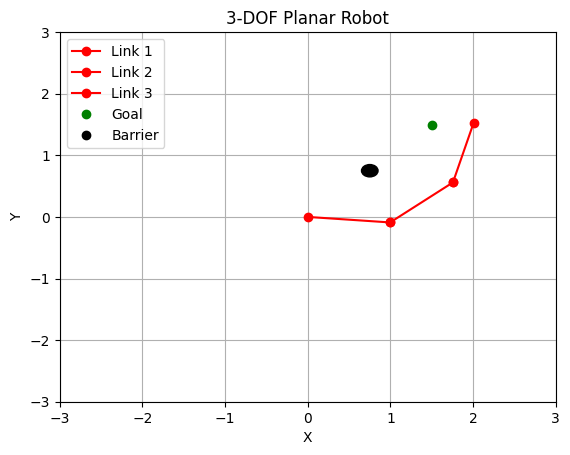

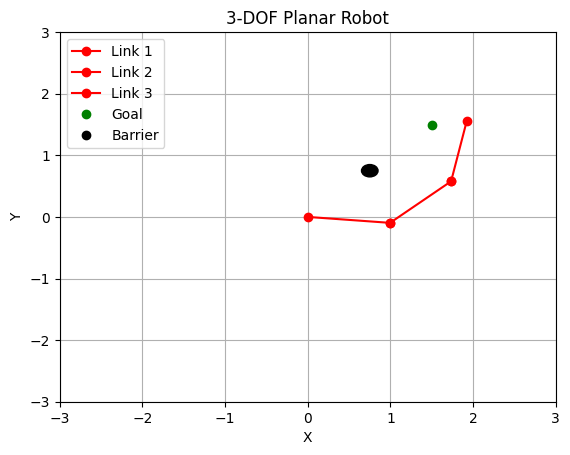

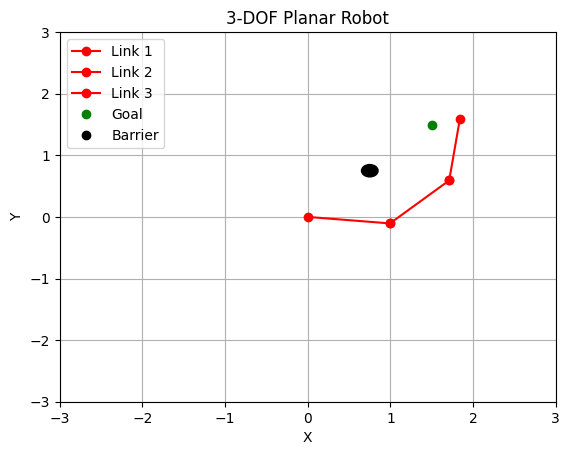

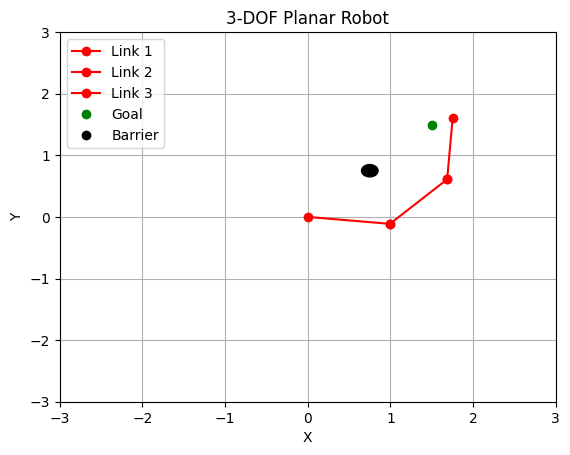

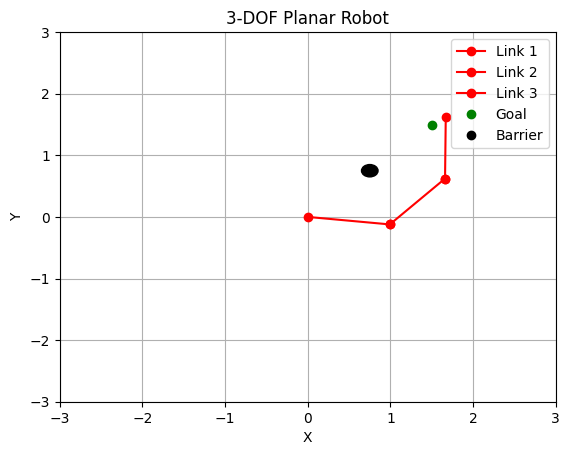

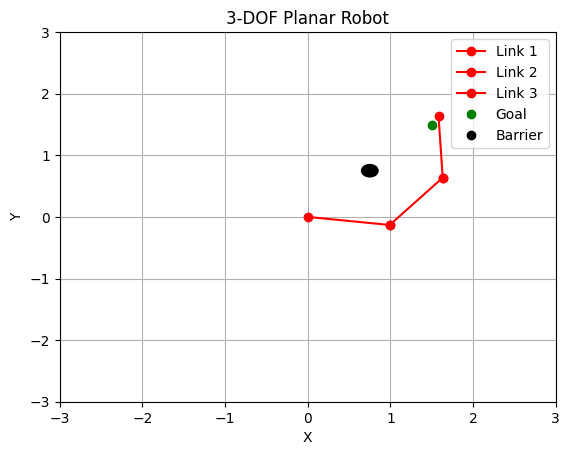

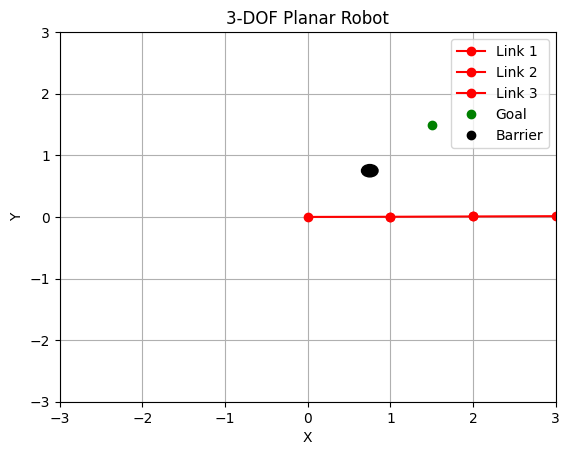

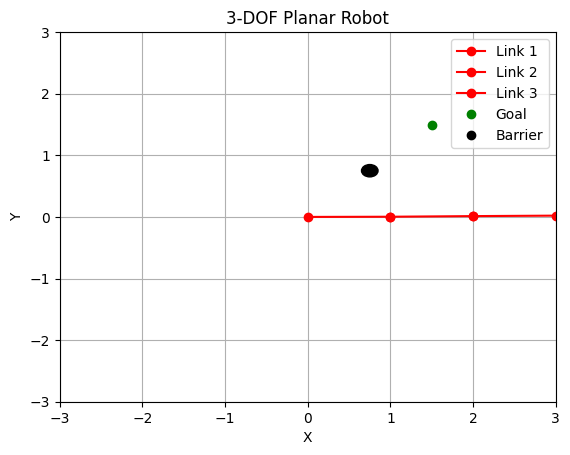

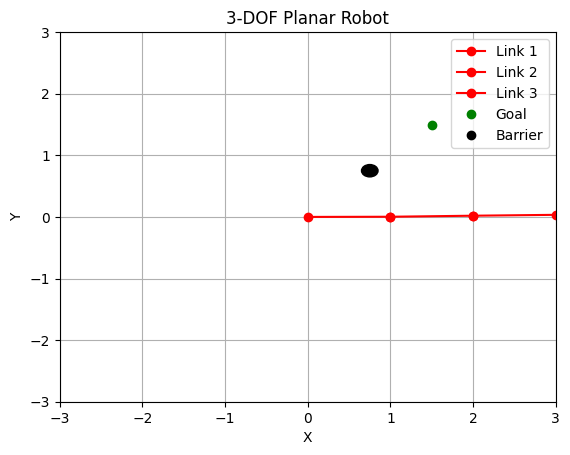

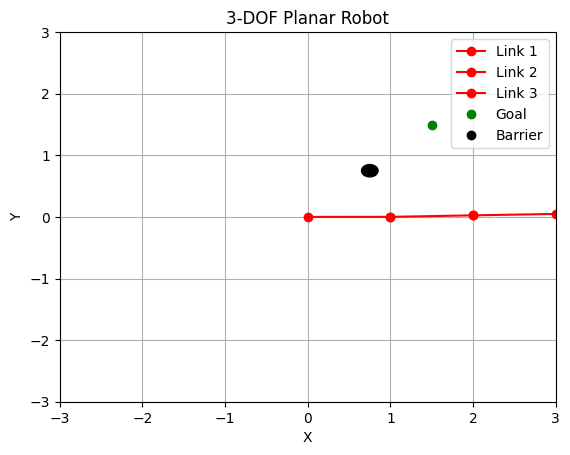

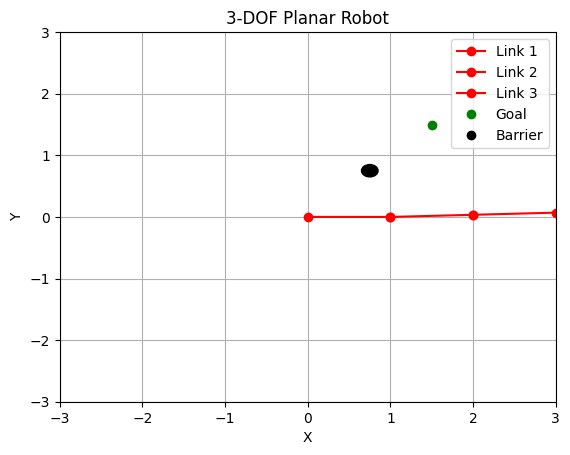

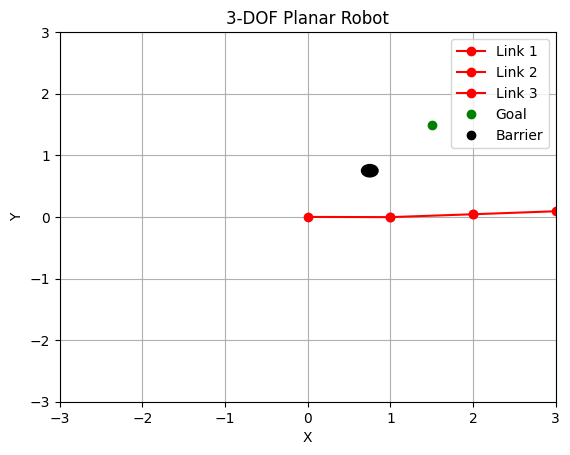

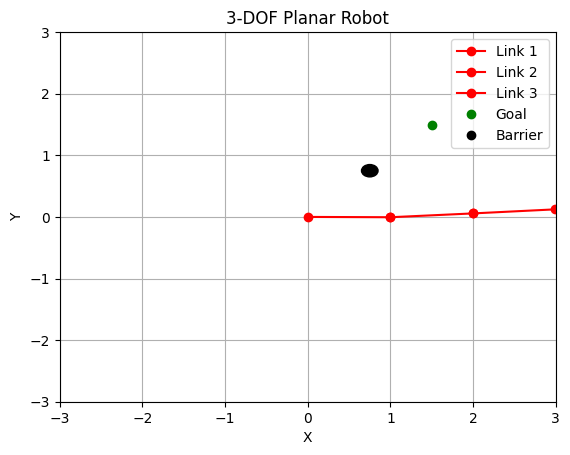

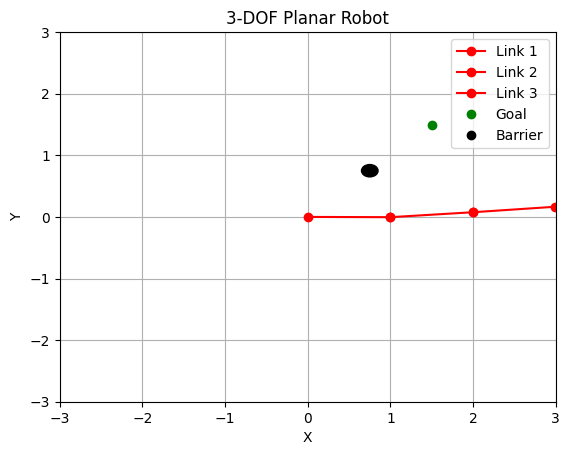

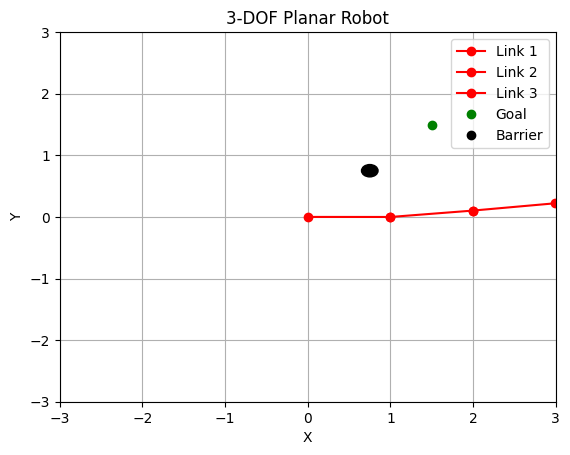

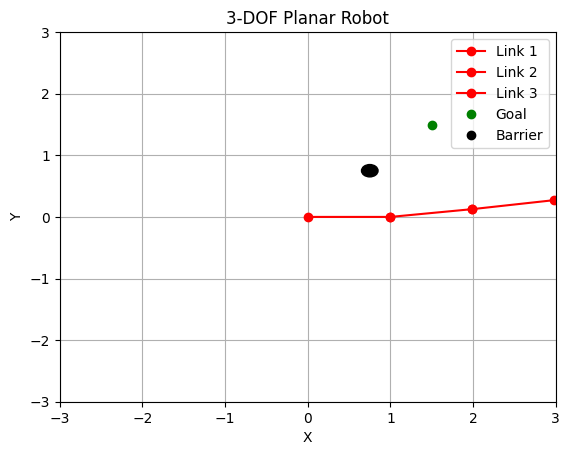

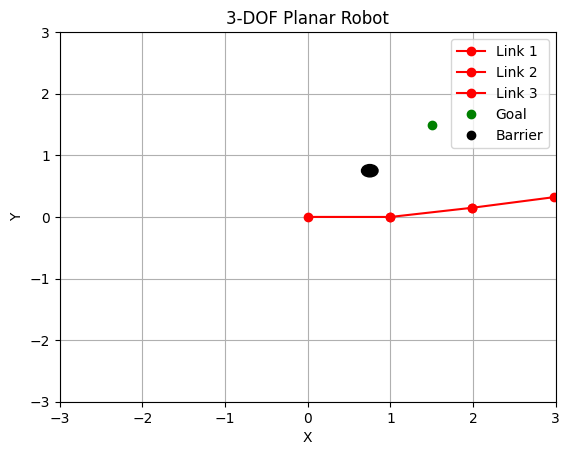

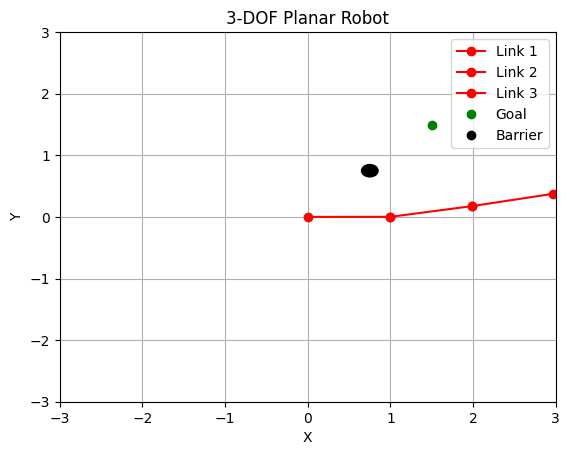

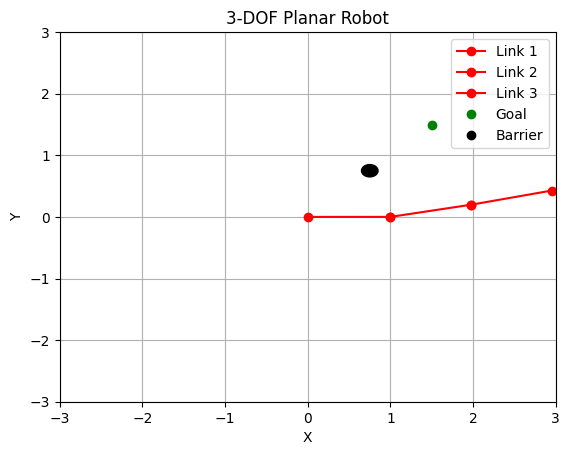

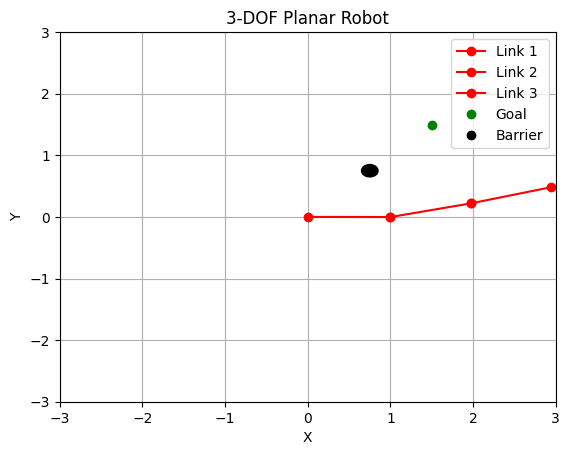

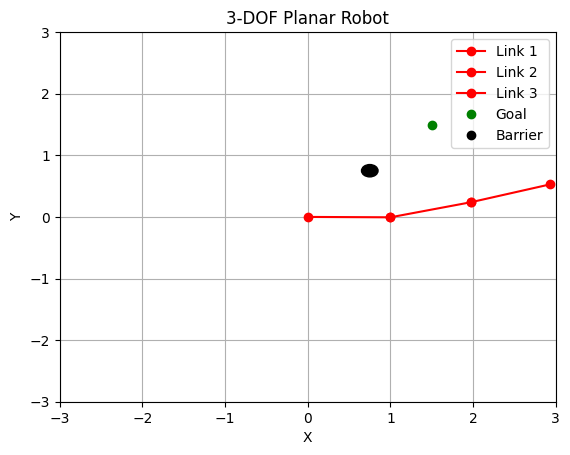

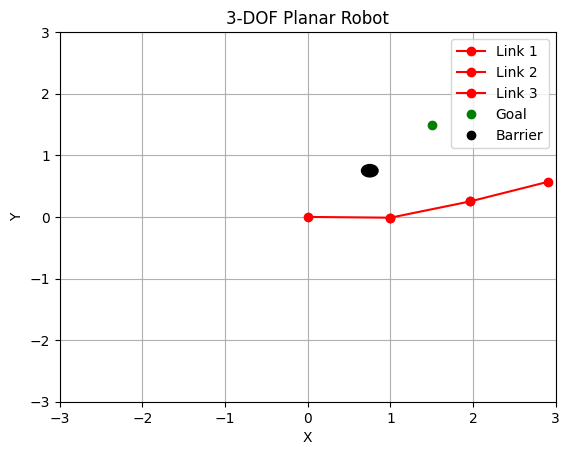

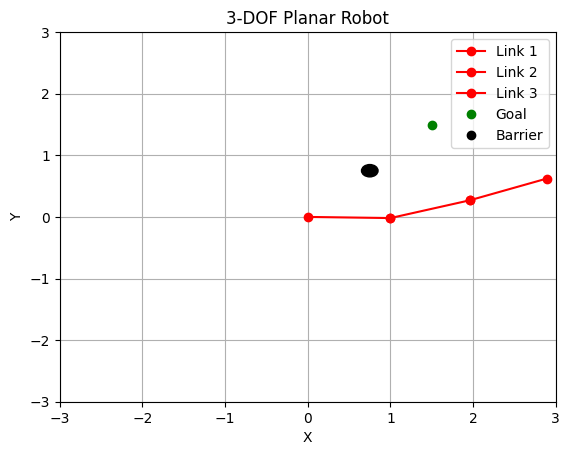

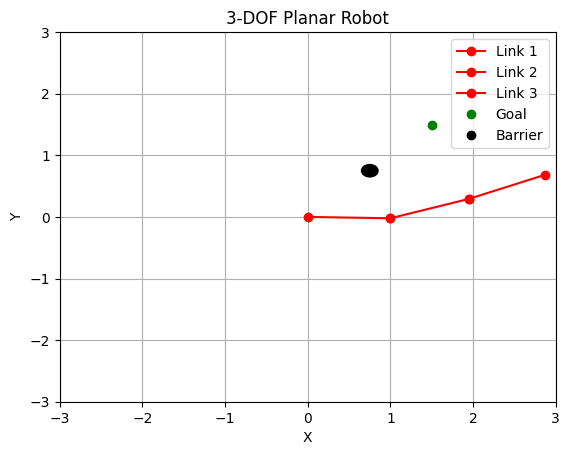

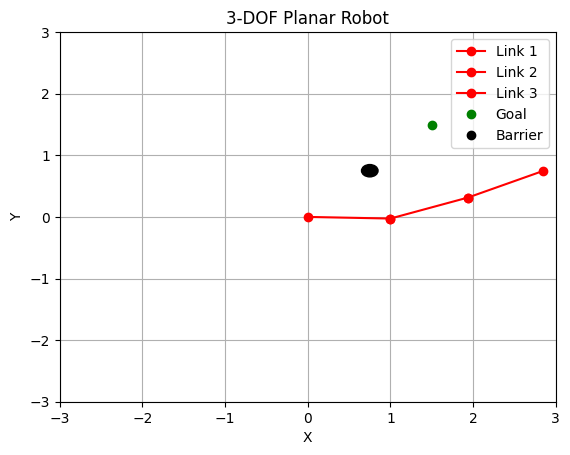

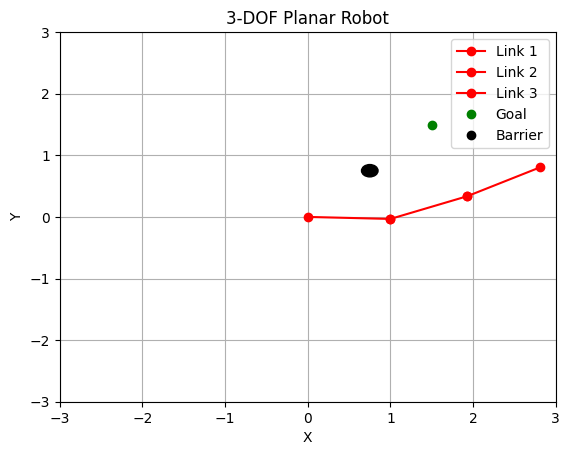

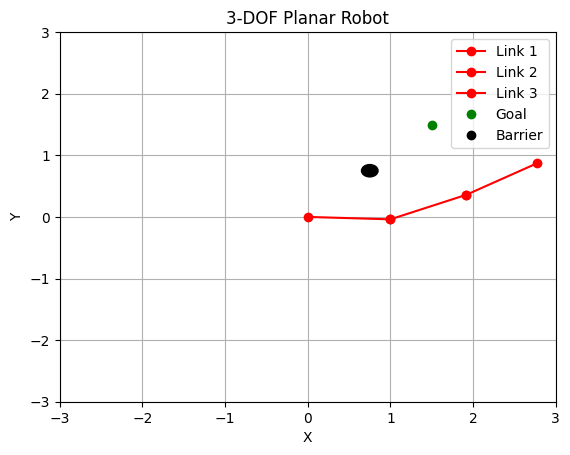

In [68]:
# Visualize the robot in the environment
obs = env.reset()
for _ in range(100):
    action, _states = model.predict(obs)
    obs, rewards, dones, info = env.step(action)
    env.render()
    if dones:
        obs = env.reset()

In [ ]:
# import gym
# from gym import spaces
# import numpy as np
# import matplotlib.pyplot as plt
# from stable_baselines3 import PPO
# from stable_baselines3.common.evaluation import evaluate_policy

# class ThreeDOFRobotEnv(gym.Env):
#     def __init__(self):
#         super(ThreeDOFRobotEnv, self).__init__()
#         self.max_torque = 2.0
#         self.max_speed = np.pi
#         self.dt = 0.05
#         self.goal = np.array([1.5, 1.5])
#         self.max_distance = 3.0  # Maximum allowable distance from the goal
#         self.barrier = np.array([0.75, 0.75])
#         self.barrier_radius = 0.1  # Radius of the barrier

#         self.action_space = spaces.Box(low=-self.max_torque, high=self.max_torque, shape=(3,), dtype=np.float32)
#         self.observation_space = spaces.Box(low=-self.max_speed, high=self.max_speed, shape=(6,), dtype=np.float32)

#         self.reset()

#     def reset(self):
#         self.state = np.zeros(6)
#         self.prev_distance = self._get_distance_to_goal()
#         self.elapsed_time = 0  # Reset the elapsed time
#         return self.state

#     def step(self, action):
#         th1, th2, th3, dth1, dth2, dth3 = self.state
#         u1, u2, u3 = action

#         dth1 = np.clip(dth1 + self.dt * u1, -self.max_speed, self.max_speed)
#         dth2 = np.clip(dth2 + self.dt * u2, -self.max_speed, self.max_speed)
#         dth3 = np.clip(dth3 + self.dt * u3, -self.max_speed, self.max_speed)

#         th1 += self.dt * dth1
#         th2 += self.dt * dth2
#         th3 += self.dt * dth3

#         self.state = np.array([th1, th2, th3, dth1, dth2, dth3])
#         self.elapsed_time += self.dt  # Increment the elapsed time

#         reward, done = self._compute_reward()
#         return self.state, reward, done, {}

#     def _get_distance_to_goal(self):
#         x = np.cos(self.state[0]) + np.cos(self.state[0] + self.state[1]) + np.cos(self.state[0] + self.state[1] + self.state[2])
#         y = np.sin(self.state[0]) + np.sin(self.state[0] + self.state[1]) + np.sin(self.state[0] + self.state[1] + self.state[2])
#         distance = np.linalg.norm(self.goal - np.array([x, y]))
#         return distance

#     def _get_joint_positions(self):
#         th1, th2, th3, _, _, _ = self.state
#         x1 = np.cos(th1)
#         y1 = np.sin(th1)
#         x2 = x1 + np.cos(th1 + th2)
#         y2 = y1 + np.sin(th1 + th2)
#         x3 = x2 + np.cos(th1 + th2 + th3)
#         y3 = y2 + np.sin(th1 + th2 + th3)
#         return np.array([[0, 0], [x1, y1], [x2, y2], [x3, y3]])

#     def _check_collision_with_barrier(self):
#         joint_positions = self._get_joint_positions()
#         for pos in joint_positions:
#             if np.linalg.norm(pos - self.barrier) <= self.barrier_radius:
#                 return True
#         return False

#     def _compute_reward(self):
#         current_distance = self._get_distance_to_goal()
#         reward = 0
#         done = False

#         if self._check_collision_with_barrier():
#             reward -= 5.0  # Heavy penalty for collision with barrier
#             done = True
#         elif current_distance > self.max_distance:
#             reward -= 1.0  # Penalty for being too far from the goal
#             done = True
#         elif current_distance < 0.1:
#             reward += 1.0  # Reward for reaching the goal
#             done = True
#         else:
#             reward += (self.prev_distance - current_distance) * 10  # Reward for getting closer to the goal
#             reward -= 0.01 * self.elapsed_time  # Small penalty for time taken

#         self.prev_distance = current_distance

#         # Encourage smoother movements by penalizing large velocities
#         reward -= 0.1 * (abs(self.state[3]) + abs(self.state[4]) + abs(self.state[5]))

#         return reward, done

#     def render(self, mode='human'):
#         th1, th2, th3, _, _, _ = self.state
#         x1 = np.cos(th1)
#         y1 = np.sin(th1)
#         x2 = x1 + np.cos(th1 + th2)
#         y2 = y1 + np.sin(th1 + th2)
#         x3 = x2 + np.cos(th1 + th2 + th3)
#         y3 = y2 + np.sin(th1 + th2 + th3)

#         plt.figure()
#         plt.plot([0, x1], [0, y1], 'ro-')
#         plt.plot([x1, x2], [y1, y2], 'ro-')
#         plt.plot([x2, x3], [y2, y3], 'ro-')
#         plt.plot(self.goal[0], self.goal[1], 'go')
#         plt.plot(self.barrier[0], self.barrier[1], 'ko')
#         circle = plt.Circle(self.barrier, self.barrier_radius, color='k', fill=True)
#         plt.gca().add_patch(circle)
#         plt.xlim(-3, 3)
#         plt.ylim(-3, 3)
#         plt.xlabel("X")
#         plt.ylabel("Y")
#         plt.title("3-DOF Planar Robot")
#         plt.legend(["Link 1", "Link 2", "Link 3", "Goal", "Barrier"])
#         plt.grid()
#         plt.show()
